# Finding the Maximum of a Function Using Bayesian Optimization (BO)

## *Using BO to find the inputs in a search space that optimize a certain output*

In this tutorial we will learn how to use Bayesian optimization to locate the global optimal value for an unknown objective function.

**Outline:**
1. Define objective function, and account for possibly noisy measurements
2. Define and fit surrogate function -- we will use Gaussian process regression.  For now, treat this as a black box.
3. Define acquision function and put it all together

**Get started:** Click "Shift-Enter" to run the code in each cell.

## <ins>Let's begin</ins>

We will first import the relevant Python libraries.

In [1]:
# import all relevant libraries

import numpy as np 
from math import pi
from scipy.stats import norm
from numpy.random import normal
from numpy.random import random
from numpy import vstack
from matplotlib import pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

## <ins>1. Define the objective function</ins>

Below, we will set the objective function here.  For good practice, we will also include for the possibility of noisy measurements to account for the fact that your actual evaluations of the objective function (say, the synthesis experiments that we do) may return noisy values.  Our objective function is 

### $f(x) = x \sin (x) \quad$   for $x$ $\varepsilon$ $[0,10]$. 

Remember that in reality, the objective function is unknown.  It is also usually something that is costly to evaluate (each experiment takes time and resources), so you want to minimize the number of evaluations needed to find the maximum. 

In [2]:
# objective function
def objective(x, noise=0):
    y = x * np.sin(x)     
    dy = 0.5 + 1.0 * np.random.normal(0,noise,y.shape)
    y += dy
    return y

Now, let us define a grid-based sample of inputs in increments of 0.1 between 0 and 10, and evaluate the objective function with noise just to see what it looks like. Try changing the amount of noise present to see how it affects the sampling.

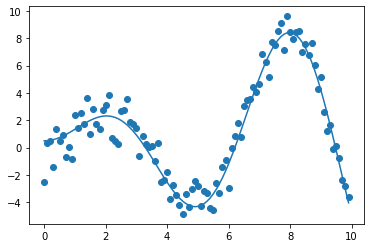

In [9]:
X = np.atleast_2d(np.arange(0,10,0.1)).T
y = objective(X).ravel() 
ynoise = objective(X,1).ravel() 

# plot the objective function without and with noise 
plt.plot(X, y)
plt.scatter(X, ynoise)
plt.show()

And below, we can look at the non-noisy objective function to find the true input that maximizes the output.

Remember that we would not know this in practice, but for out test problem, it is good to know 
the real best input and output of the function to see if the Bayesian Optimization 
algorithm can actually locate it.

In [8]:
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=8.000, y=8.415


## <ins>2. Create the surrogate function - Gaussian Process Models</ins> 

Remember that the surrogate function is the way that we approximate the actual function, using the data that we currently have. 

The surrogate function estimates the conditional probability that the unknown objective function is equal to $f$, given the available data $D$ we have. That is, our surrogate function is $P(f|D)$ and we use Bayes Theorem to evaluate it. 

There are many ways to estimate the conditional probability.   We will do it here using a Gaussian Process (GP) model.  This is a type of regression model that we will discuss in more detail later. We can obtain a GP regression model using the GaussianProcesssRegressor scikit-learn implementation.  We just need to fit our sample inputs (called $X$ above) to our noisy evaluations of the objective function (called $ynoise$).

Below, we define three functions.  The first is the objective function, same as above. The second is the surrogate model, which returns the predicted value and standard deviation of the objective function. The second function allows us to make nice plots to compare the actual objective function, our measurements of it, and the predictions and uncertainty of the surrogate model. 

In [10]:
# objective function
def objective(x, noise=0):
    y = x * np.sin(x)     
    dy = 0.5 + 1.0 * np.random.normal(0,noise,y.shape)
    y += dy
    return y

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# plot real observations vs surrogate function
def plot(X, y, model, ax=None, legend=True):
    if ax is None:
        ax = plt.gca()
    # plot the predictions of the surrogate function across domain
    Xmesh = np.atleast_2d(np.linspace(0, 10, 1000)).T
    ypred, ystd = surrogate(model,Xmesh)
    ax.plot(Xmesh, objective(Xmesh), 'r:', label=r'objective function $f(x) = x\,\sin(x)$')
    ax.plot(X, y, 'ro', markersize=10, label='Observations', mew=1, mec='k', alpha=0.7)
    ax.plot(Xmesh, ypred, 'b-', label='Surrogate model prediction')
    ax.fill(np.concatenate([Xmesh, Xmesh[::-1]]),
         np.concatenate([ypred - 1.9600 * ystd,
                        (ypred + 1.9600 * ystd)[::-1]]),
         alpha=.5, fc='b', ec='None', label='surrogate model 95% confidence interval')
    ax.set_xlim(0, 10)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.set_ylim(-10, 20)
    if legend:
        ax.legend(loc='upper left')

With our functions defined, let's define a gaussian process model and try it out.  We are going to do this a few different ways.  First we will assume that we start with six measurements on an evenly spaced grid -- first with and then without noise.  Then we will assume that we start with six random measurements -- again with and without noise. 

### Uniformly sampled, without noise:

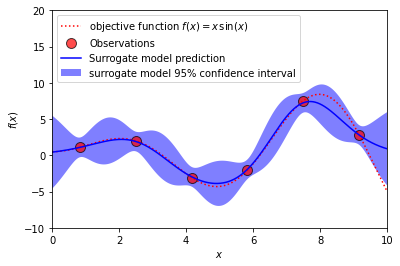

In [25]:
# sample the domain sparsely without noise
X = np.atleast_2d([0.8333, 2.5, 4.1666, 5.83333, 7.5, 9.16666]).T
y = objective(X).ravel()

# define the model
kernels = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10))
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.5)

# fit the model
gp.fit(X, y)

# plot the surrogate function
plot(X, y, gp)

### Uniformly sampled, with noise:

Run this cell a few times and observe how the effects of noisy measurements affect our understanding of the model.  Try varying the amount of noise. Your mileage may vary.

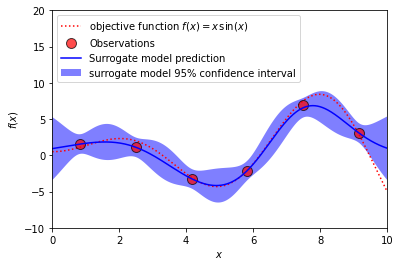

In [28]:
# sample the domain sparsely with noise
X = np.atleast_2d([0.8333, 2.5, 4.1666, 5.83333, 7.5, 9.16666]).T
y = objective(X,1).ravel()
# define the model
#kernels = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10))
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.5)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp)

plt.savefig('bayes.pdf')

### Randomly sampled, without noise: 

Run this a few times too. 

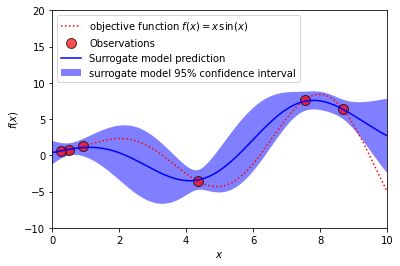

In [29]:
# sample the domain sparsely without noise
X = 10*random(6)
X = np.atleast_2d(X).T
y = objective(X).ravel()
# define the model
#kernels = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10))
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.5)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp)

### Randomly sampled, with noise 

Run this one a few times.

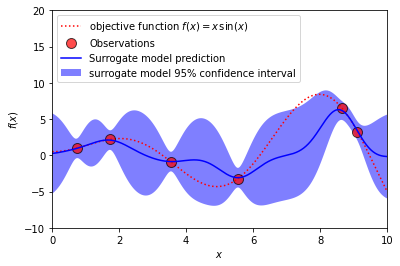

In [35]:
# sample the domain sparsely with noise
X = 10*random(6)
X = np.atleast_2d(X).T
y = objective(X,0.01).ravel()
# define the model
#kernels = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10))
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.5)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp)

## <ins>3. Define our acquisition function, execute search</ins> 

Here we will put everything together.  The question now becomes one of search.  Given our current understanding of of the objective function (our surrogate model prediction and its uncertainty), what is the next experiment we should do to grow our data set?  Remember that real measurements (experiments) are expensive.  So we want this search to guide us to the maximum in as few steps as possible.

Two pieces are needed:

 1. a search strategy to navigate the search space using the surrogate function 
 2. an acquisition function that interprets and scores the response from the surrogate function.

The search strategy can be random sampling, grid-based sampling, or some sort of local search 
strategy (BFGS). We will go with random sampling of the domain just to keep things simple. This involves first drawing a random sample from the domain, and evaluating the expected outcome of the experiment for each candidate, then maximizing the acquisition function (choosing the candidate sample that gives the best score). The opt_acquisition() function below implements this. Three options for the aqcuisition function are provided: exploitation, exploration, and maximum probability of improvement.

In [41]:
# maximum expected improvement acquisition function (EXPLOITATION)
def acquisition_EI(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:]
    # calculate the probability of improvement
    probs = norm.cdf((mu))
    return probs

# maximum uncertainty acquisition function (EXPLORATION)
def acquisition_U(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:]
    # calculate the probability of improvement
    probs = norm.cdf(std+1E-9)
    return probs

# probability of improvement acquisition function
def acquisition_PI(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = 10*random(100)
    Xsamples = np.atleast_2d(Xsamples).T    
    # calculate the acquisition function for each sample
    scores = acquisition_U(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix, 0]

This is initialized to pick 6 starting points at random, and sample the objective function with noise of 0.25. 
Let's see how effectively the acquisition function guides us to the maximum.

Once you have understood what it does, try varying the acquisition function and the number of starting measurements (see what happens if you reduce it from six).  Another thing that you can try is reducing or increasing the amount of noise in the measurements. 

>x=9.844, f()=-0.010772, actual=-3.504
>x=7.553, f()=-2.046608, actual=7.713
>x=3.852, f()=-0.504704, actual=-2.012
>x=8.577, f()=3.287729, actual=6.932
Best Result: x=7.553, y=7.713


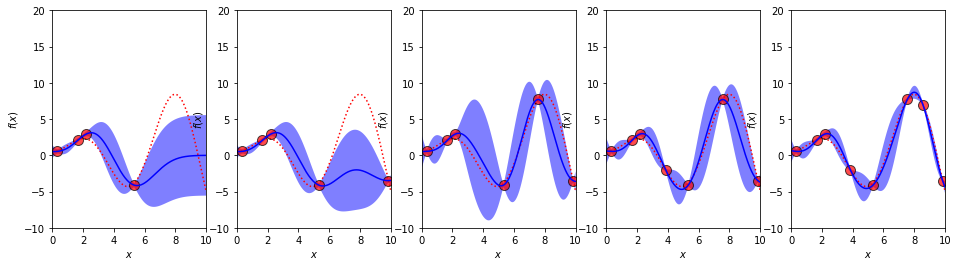

In [43]:
niterations=4
fig, axes=plt.subplots(1,niterations+1,figsize=(niterations*4,4))
# sample the domain randomly without noise, starting with six measurements 
X = 10*random(4)
X = np.atleast_2d(X).T
y = objective(X,0.25).ravel()
# define the model
#kernels = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10))
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.025)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp, ax=axes[0], legend=False)

# perform the optimization process 
# we will go for four steps 
for i in range(niterations):
    # select the next point to sample
    x = opt_acquisition(X, y, gp)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(gp, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = np.append(y,actual)
    # update the model
    gp.fit(X, y)
    plot(X,y,gp, ax=axes[i+1], legend=False)
 
# plot all samples and the final surrogate function
# best result
ix = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))